<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Youssef%20O/data_prep_initial_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nilearn

In [ ]:
import sys
import os
sys.path.append('/content/drive/MyDrive/')
main_path = '/content/drive/MyDrive/ABIDE'
if not os.path.exists(main_path):
  os.makedirs(main_path)

In [ ]:
# download subject_IDs.txt
phenotypic_path = main_path + '/phenotypic_image_quality'
if not os.path.exists(phenotypic_path):
  os.makedirs(phenotypic_path)
!gdown 1-71vU67genAR0h6QwJdBzkeAfnOSfqHE --output /content/drive/MyDrive/ABIDE/phenotypic_image_quality/


Downloading...
From: https://drive.google.com/uc?id=1-71vU67genAR0h6QwJdBzkeAfnOSfqHE
To: /content/drive/MyDrive/ABIDE/phenotypic_image_quality/subject_IDs.txt
100% 5.23k/5.23k [00:00<00:00, 11.7MB/s]


In [ ]:
# Prepare AAL data

from nilearn import datasets
from nilearn import connectome
import scipy.io as sio
import numpy as np
import shutil

def get_ids(data_folder,num_subjects=None):
    """
    return:
        subject_IDs    : list of all subject IDs
    """
    subject_IDs = np.genfromtxt(os.path.join(data_folder, 'subject_IDs.txt'), dtype=str)
    if num_subjects is not None:
        subject_IDs = subject_IDs[:num_subjects]
    return subject_IDs

def fetch_filenames(data_folder,subject_IDs, file_type):
    """
        subject_list : list of short subject IDs in string format
        file_type    : must be one of the available file types
    returns:
        filenames    : list of filetypes (same length as subject_list)
    """
    import glob
    # Specify file mappings for the possible file types
    filemapping = {'func_preproc': '_func_preproc.nii.gz',
                   'rois_aal': '_rois_aal.1D'}
    # The list to be filled
    filenames = []
    # Fill list with requested file paths
    for i in range(len(subject_IDs)):
        os.chdir(data_folder)
        try:
            filenames.append(glob.glob('*' + subject_IDs[i] + filemapping[file_type])[0])
        except IndexError:
            # Return N/A if subject ID is not found
            filenames.append('N/A')
    return filenames

def get_timeseries(data_folder,subject_list, atlas_name):
    """
        subject_list : list of short subject IDs in string format
        atlas_name   : the atlas based on which the timeseries are generated e.g. aal, cc200

    returns:
        time_series  : list of timeseries arrays, each of shape (timepoints x regions)
    """
    timeseries = []
    for i in range(len(subject_list)):
        subject_folder = os.path.join(data_folder, subject_list[i])
        ro_file = [f for f in os.listdir(subject_folder) if f.endswith('_rois_' + atlas_name + '.1D')]
        print(ro_file[0])
        fl = os.path.join(subject_folder, ro_file[0])
        print("Reading timeseries file %s" %fl)
        timeseries.append(np.loadtxt(fl, skiprows=0))
    return timeseries

def subject_connectivity(timeseries, subject, atlas_name, kind, save_path, save=True):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subject      : the subject ID
        atlas_name   : name of the parcellation atlas used
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        save         : save the connectivity matrix to a file
        save_path    : specify path to save the matrix if different from subject folder

    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    print("Estimating %s matrix for subject %s" % (kind, subject))

    if kind in ['tangent', 'partial correlation', 'correlation']:
        conn_measure = connectome.ConnectivityMeasure(kind=kind)
        connectivity = conn_measure.fit_transform([timeseries])[0]

    if save:
        subject_file = os.path.join(save_path, subject + '.mat')
        sio.savemat(subject_file, {'connectivity': connectivity})

    return connectivity



AAL_path = main_path + '/AAL/original/'
data_folder = AAL_path + 'ABIDE_pcp/cpac/filt_noglobal'
if not os.path.exists(AAL_path):
  os.makedirs(AAL_path)
pipeline = 'cpac'
num_subjects = 5  # Number of subjects
files = ['rois_aal']
filemapping = {'func_preproc': 'func_preproc.nii.gz',
               'rois_aal': 'rois_aal.1D'}

abide = datasets.fetch_abide_pcp(data_dir=AAL_path, n_subjects=num_subjects, pipeline=pipeline,
                 band_pass_filtering=True, global_signal_regression=False, derivatives=files)


subject_IDs = get_ids(phenotypic_path,num_subjects)
subject_IDs = subject_IDs.tolist()

for s, fname in zip(subject_IDs, fetch_filenames(data_folder, subject_IDs, files[0])):
    subject_folder = os.path.join(data_folder, s)
    if not os.path.exists(subject_folder):
        os.mkdir(subject_folder)

    # Get the base filename for each subject
    base = fname.split(files[0])[0]

    # Move each subject file to the subject folder
    for fl in files:
        if not os.path.exists(os.path.join(subject_folder, base + filemapping[fl])):
            shutil.move(base + filemapping[fl], subject_folder)

time_series = get_timeseries(data_folder,subject_IDs, 'aal')

# Compute and save connectivity matrices
for i in range(len(subject_IDs)):
    subject_connectivity(time_series[i], subject_IDs[i], 'aal', 'correlation',AAL_path)



[fetch_abide_pcp] Added README.md to /content/drive/MyDrive/ABIDE/AAL/original/

[fetch_abide_pcp] Dataset created in /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal/Pitt_0050003_r
ois_aal.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal/Pitt_0050004_r
ois_aal.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal/Pitt_0050005_r
ois_aal.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal/Pitt_0050006_r
ois_aal.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal/Pitt_0050007_r
ois_aal.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

Pitt_0050003_rois_aal.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal/50003/Pitt_0050003_rois_aal.1D
Pitt_0050004_rois_aal.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal/50004/Pitt_0050004_rois_aal.1D
Pitt_0050005_rois_aal.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal/50005/Pitt_0050005_rois_aal.1D
Pitt_0050006_rois_aal.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal/50006/Pitt_0050006_rois_aal.1D
Pitt_0050007_rois_aal.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal/50007/Pitt_0050007_rois_aal.1D
Estimating correlation matrix for subject 50003
Estimating correlation matrix for subject 50004
Estimating correlation matrix for subject 50005
Estimating correlation matrix for subject 50006
Estimating correlation matrix for subject 50007


In [ ]:
################### download labels, collection sites, age, gender, FIQS .mat files #################################
import csv


phenotype = os.path.join(AAL_path, 'ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv')

def get_subject_score(phenotype,subject_list, score):
    scores_dict = {}

    with open(phenotype) as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['SUB_ID'] in subject_list:
                scores_dict[row['SUB_ID']] = row[score]

    return scores_dict

ages_dist = get_subject_score(phenotype, subject_IDs, score='AGE_AT_SCAN')
genders_dist = get_subject_score(phenotype, subject_IDs, score='SEX')
labels_dist = get_subject_score(phenotype, subject_IDs, score='DX_GROUP')
sites_dist = get_subject_score(phenotype, subject_IDs, score='SITE_ID')
FIQS_dist = get_subject_score(phenotype, subject_IDs, score='FIQ')
NUM_dist = get_subject_score(phenotype, subject_IDs, score='func_num_fd')
PEC_dist = get_subject_score(phenotype, subject_IDs, score='func_perc_fd')
RAT_dist = get_subject_score(phenotype, subject_IDs, score='qc_anat_rater_2')
ages = list(ages_dist.values())
genders = list(genders_dist.values())
labels = list(labels_dist.values())
sites = list(sites_dist.values())
FIQS_all = list(FIQS_dist.values())
NUM_all = list(NUM_dist.values())
PEC_all = list(PEC_dist.values())
RAT_all = list(RAT_dist.values())

labels_array = np.zeros((2,num_subjects))
NUM = np.zeros([num_subjects, 1], dtype=np.int64)
PEC = np.zeros([num_subjects, 1], dtype=np.float64)
RAT = np.zeros([num_subjects, 1], dtype=np.int64)
FIQS = np.zeros([num_subjects, 1], dtype=np.float64)


for i in range(num_subjects):

    NUM[i] = NUM_all[i]
    PEC[i] = PEC_all[i]

    if FIQS_all[i] == '':
        FIQS[i] = -9999
    else:
        FIQS[i] = FIQS_all[i]

    if labels[i] == '1':
        labels_array[0, i] = 1
    else:
        labels_array[1, i] = 1

    if RAT_all[i] == 'OK':
        RAT[i]=1
    elif RAT_all[i] == 'maybe':
        RAT[i]=2
    elif RAT_all[i] == 'fail':
        RAT[i]=3

sio.savemat(os.path.join(phenotypic_path, 'ages.mat'), {'ages': ages})
sio.savemat(os.path.join(phenotypic_path, 'genders.mat'), {'genders': genders})
sio.savemat(os.path.join(phenotypic_path, 'sites.mat'), {'sites': sites})
sio.savemat(os.path.join(phenotypic_path, 'FIQS.mat'), {'FIQS': FIQS})
sio.savemat(os.path.join(phenotypic_path, 'NUM.mat'), {'NUM': NUM})
sio.savemat(os.path.join(phenotypic_path, 'PEC.mat'), {'PEC': PEC})
sio.savemat(os.path.join(phenotypic_path, 'RAT.mat'), {'RAT': RAT})
sio.savemat(os.path.join(phenotypic_path, 'ABIDE_label_871.mat'), {'label': labels_array})

In [ ]:
labels_array = np.zeros((2,num_subjects))
!pwd
os.chdir("/content/drive/MyDrive/ABIDE/AAL/original/")
!pwd
!rm -rf ABIDE_pcp

/content/drive/MyDrive/ABIDE/AAL/original/ABIDE_pcp/cpac/filt_noglobal
/content/drive/MyDrive/ABIDE/AAL/original


In [ ]:
# Prepare CC200 data

from nilearn import datasets
from nilearn import connectome
import scipy.io as sio
import numpy as np
import shutil

def get_ids(data_folder,num_subjects=None):
    """
    return:
        subject_IDs    : list of all subject IDs
    """
    subject_IDs = np.genfromtxt(os.path.join(data_folder, 'subject_IDs.txt'), dtype=str)
    if num_subjects is not None:
        subject_IDs = subject_IDs[:num_subjects]
    return subject_IDs

def fetch_filenames(data_folder,subject_IDs, file_type):
    """
        subject_list : list of short subject IDs in string format
        file_type    : must be one of the available file types
    returns:
        filenames    : list of filetypes (same length as subject_list)
    """
    import glob
    # Specify file mappings for the possible file types
    filemapping = {'func_preproc': '_func_preproc.nii.gz',
                   'rois_cc200': '_rois_cc200.1D'}
    # The list to be filled
    filenames = []
    # Fill list with requested file paths
    for i in range(len(subject_IDs)):
        os.chdir(data_folder)
        try:
            filenames.append(glob.glob('*' + subject_IDs[i] + filemapping[file_type])[0])
        except IndexError:
            # Return N/A if subject ID is not found
            filenames.append('N/A')
    return filenames

def get_timeseries(data_folder,subject_list, atlas_name):
    """
        subject_list : list of short subject IDs in string format
        atlas_name   : the atlas based on which the timeseries are generated e.g. aal, cc200

    returns:
        time_series  : list of timeseries arrays, each of shape (timepoints x regions)
    """
    timeseries = []
    for i in range(len(subject_list)):
        subject_folder = os.path.join(data_folder, subject_list[i])
        ro_file = [f for f in os.listdir(subject_folder) if f.endswith('_rois_' + atlas_name + '.1D')]
        print(ro_file[0])
        fl = os.path.join(subject_folder, ro_file[0])
        print("Reading timeseries file %s" %fl)
        timeseries.append(np.loadtxt(fl, skiprows=0))
    return timeseries

def subject_connectivity(timeseries, subject, atlas_name, kind, save_path, save=True):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subject      : the subject ID
        atlas_name   : name of the parcellation atlas used
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        save         : save the connectivity matrix to a file
        save_path    : specify path to save the matrix if different from subject folder

    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    print("Estimating %s matrix for subject %s" % (kind, subject))

    if kind in ['tangent', 'partial correlation', 'correlation']:
        conn_measure = connectome.ConnectivityMeasure(kind=kind)
        connectivity = conn_measure.fit_transform([timeseries])[0]

    if save:
        subject_file = os.path.join(save_path, subject + '.mat')
        sio.savemat(subject_file, {'connectivity': connectivity})

    return connectivity



CC200_path = main_path + '/CC200/original/'
data_folder = CC200_path + 'ABIDE_pcp/cpac/filt_noglobal'
if not os.path.exists(CC200_path):
  os.makedirs(CC200_path)
pipeline = 'cpac'
num_subjects = 5  # Number of subjects
files = ['rois_cc200']
filemapping = {'func_preproc': 'func_preproc.nii.gz',
               'rois_cc200': 'rois_cc200.1D'}

abide = datasets.fetch_abide_pcp(data_dir=CC200_path, n_subjects=num_subjects, pipeline=pipeline,
                 band_pass_filtering=True, global_signal_regression=False, derivatives=files)


subject_IDs = get_ids(phenotypic_path,num_subjects)
subject_IDs = subject_IDs.tolist()

for s, fname in zip(subject_IDs, fetch_filenames(data_folder, subject_IDs, files[0])):
    subject_folder = os.path.join(data_folder, s)
    if not os.path.exists(subject_folder):
        os.mkdir(subject_folder)

    # Get the base filename for each subject
    base = fname.split(files[0])[0]

    # Move each subject file to the subject folder
    for fl in files:
        if not os.path.exists(os.path.join(subject_folder, base + filemapping[fl])):
            shutil.move(base + filemapping[fl], subject_folder)

time_series = get_timeseries(data_folder,subject_IDs, 'cc200')

# Compute and save connectivity matrices
for i in range(len(subject_IDs)):
    subject_connectivity(time_series[i], subject_IDs[i], 'cc200', 'correlation',CC200_path)

[fetch_abide_pcp] Added README.md to /content/drive/MyDrive/ABIDE/CC200/original/

[fetch_abide_pcp] Dataset created in /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_cc200/Pitt_0050003
_rois_cc200.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_cc200/Pitt_0050004
_rois_cc200.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_cc200/Pitt_0050005
_rois_cc200.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_cc200/Pitt_0050006
_rois_cc200.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_cc200/Pitt_0050007
_rois_cc200.1D ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

Pitt_0050003_rois_cc200.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal/50003/Pitt_0050003_rois_cc200.1D
Pitt_0050004_rois_cc200.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal/50004/Pitt_0050004_rois_cc200.1D
Pitt_0050005_rois_cc200.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal/50005/Pitt_0050005_rois_cc200.1D
Pitt_0050006_rois_cc200.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal/50006/Pitt_0050006_rois_cc200.1D
Pitt_0050007_rois_cc200.1D
Reading timeseries file /content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal/50007/Pitt_0050007_rois_cc200.1D
Estimating correlation matrix for subject 50003
Estimating correlation matrix for subject 50004
Estimating correlation matrix for subject 50005
Estimating correlation matrix for subject 50006
Estimating correlation 

In [ ]:
!pwd
os.chdir("/content/drive/MyDrive/ABIDE/CC200/original/")
!pwd
!rm -rf ABIDE_pcp

/content/drive/MyDrive/ABIDE/CC200/original/ABIDE_pcp/cpac/filt_noglobal
/content/drive/MyDrive/ABIDE/CC200/original


In [ ]:
# download sMRI data
!gdown 1E18xuQ-BbspSuuFIhJ2AiI4RsPKwqTCy --output /content/drive/MyDrive/ABIDE/

Downloading...
From (original): https://drive.google.com/uc?id=1E18xuQ-BbspSuuFIhJ2AiI4RsPKwqTCy
From (redirected): https://drive.google.com/uc?id=1E18xuQ-BbspSuuFIhJ2AiI4RsPKwqTCy&confirm=t&uuid=c5f8d4b4-017e-46b8-9660-25de5294c813
To: /content/drive/MyDrive/ABIDE/freesurfer_stats.zip
100% 39.6M/39.6M [00:00<00:00, 128MB/s]


In [ ]:
# Create CNN directory
CNN_path = main_path + '/CNN/original/'
if not os.path.exists(CNN_path):
    os.makedirs(CNN_path)

# Download ONLY the fMRI volumes for CNN
files = ['func_preproc']  # Only what you need for CNN

abide = datasets.fetch_abide_pcp(data_dir=CNN_path, n_subjects=len(subject_IDs), pipeline='cpac',
                 band_pass_filtering=True, global_signal_regression=False, derivatives=files)

[fetch_abide_pcp] Added README.md to /content/drive/MyDrive/ABIDE/CNN/original/

[fetch_abide_pcp] Dataset created in /content/drive/MyDrive/ABIDE/CNN/original/ABIDE_pcp

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv ...

[fetch_abide_pcp]  ...done. (1 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/func_preproc/Pitt_00500
03_func_preproc.nii.gz ...

[fetch_abide_pcp] Downloaded 15351808 of 104448665 bytes (14.7%%,    5.9s remaining)

[fetch_abide_pcp] Downloaded 49299456 of 104448665 bytes (47.2%%,    2.3s remaining)

[fetch_abide_pcp] Downloaded 86065152 of 104448665 bytes (82.4%%,    0.6s remaining)

[fetch_abide_pcp]  ...done. (4 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/func_preproc/Pitt_00500
04_func_preproc.nii.gz ...

[fetch_abide_pcp] Downloaded 12402688 of 108061653 bytes (11.5%%,    7.7s remaining)

[fetch_abide_pcp] Downloaded 40542208 of 108061653 bytes (37.5%%,    3.4s remaining)

[fetch_abide_pcp] Downloaded 71696384 of 108061653 bytes (66.3%%,    1.5s remaining)

[fetch_abide_pcp] Downloaded 103301120 of 108061653 bytes (95.6%%,    0.2s remaining)

[fetch_abide_pcp]  ...done. (5 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/func_preproc/Pitt_00500
05_func_preproc.nii.gz ...

[fetch_abide_pcp] Downloaded 4014080 of 110574559 bytes (3.6%%,   26.6s remaining)

[fetch_abide_pcp] Downloaded 13647872 of 110574559 bytes (12.3%%,   14.2s remaining)

[fetch_abide_pcp] Downloaded 29556736 of 110574559 bytes (26.7%%,    8.3s remaining)

[fetch_abide_pcp] Downloaded 56573952 of 110574559 bytes (51.2%%,    3.8s remaining)

[fetch_abide_pcp] Downloaded 93339648 of 110574559 bytes (84.4%%,    0.9s remaining)

[fetch_abide_pcp]  ...done. (6 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/func_preproc/Pitt_00500
06_func_preproc.nii.gz ...

[fetch_abide_pcp] Downloaded 18710528 of 115244136 bytes (16.2%%,    5.2s remaining)

[fetch_abide_pcp] Downloaded 58490880 of 115244136 bytes (50.8%%,    1.9s remaining)

[fetch_abide_pcp] Downloaded 98648064 of 115244136 bytes (85.6%%,    0.5s remaining)

[fetch_abide_pcp]  ...done. (4 seconds, 0 min)

[fetch_abide_pcp] Downloading data from 
https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_noglobal/func_preproc/Pitt_00500
07_func_preproc.nii.gz ...

[fetch_abide_pcp] Downloaded 13451264 of 103017661 bytes (13.1%%,    6.7s remaining)

[fetch_abide_pcp] Downloaded 37838848 of 103017661 bytes (36.7%%,    3.5s remaining)

[fetch_abide_pcp] Downloaded 71983104 of 103017661 bytes (69.9%%,    1.3s remaining)

[fetch_abide_pcp]  ...done. (4 seconds, 0 min)

In [ ]:
downloaded_subjects = []
# Path where the subject data files are expected to be
data_folder = os.path.join(CNN_path, 'ABIDE_pcp/cpac/filt_noglobal')

if os.path.exists(data_folder):
    for filename in os.listdir(data_folder):
        if filename.endswith('_func_preproc.nii.gz'):
            # Extract subject ID from filename, e.g., 'Pitt_0050003_func_preproc.nii.gz' -> '50003'
            # Assuming the format is always 'SITE_SUBID_func_preproc.nii.gz'
            parts = filename.split('_')
            if len(parts) > 1:
                # Remove leading zeros to match the format in subject_IDs
                subject_id = parts[1].lstrip('0')
                downloaded_subjects.append(subject_id)

print(f"GNN subjects: {len(subject_IDs)}")
print(f"CNN subjects: {len(downloaded_subjects)}")
print(f"Overlap: {len(set(subject_IDs) & set(downloaded_subjects))}")

# Ensure perfect alignment
assert set(subject_IDs) == set(downloaded_subjects), "Subject mismatch!"

GNN subjects: 5
CNN subjects: 5
Overlap: 5


In [ ]:
# mkdir paths

save_model_path = main_path + '/save_models'
if not os.path.exists(save_model_path):
  os.makedirs(save_model_path)

foldernames = ['AAL','CC200','sMRI','CC200_sMRI']
modelnames = ['SVM','FCN','AUTO','GCN','EV_GCN']

for i in range(len(foldernames)):
  features_path = save_model_path + '/' + foldernames[i]
  with_phe_path = features_path + '/with_phe'
  without_phe_path = features_path + '/without_phe'
  with_phe_maxvoting_path = with_phe_path + '/Max_voting'
  without_phe_maxvoting_path = without_phe_path + '/Max_voting'
  if not os.path.exists(features_path):
    os.makedirs(features_path)
  if not os.path.exists(with_phe_path):
    os.makedirs(with_phe_path)
  if not os.path.exists(without_phe_path):
    os.makedirs(without_phe_path)
  if not os.path.exists(with_phe_maxvoting_path):
    os.makedirs(with_phe_maxvoting_path)
  if not os.path.exists(without_phe_maxvoting_path):
    os.makedirs(without_phe_maxvoting_path)

  for j in range(len(modelnames)):
    with_path = with_phe_maxvoting_path + '/' + modelnames[j]
    without_path = without_phe_maxvoting_path + '/' + modelnames[j]
    if not os.path.exists(with_path):
      os.makedirs(with_path)
    if not os.path.exists(without_path):
      os.makedirs(without_path)



In [ ]:
# download scripts

# SVM sMRI
!gdown 1KkbELF5C7f7ixfd8MX0Js2iZYmuwC39I --output /content/drive/MyDrive/ABIDE/
# SVM fMRI
!gdown 1Exv0Iaf7ck3GZqV0w0wQtrt8DMm9UC8m --output /content/drive/MyDrive/ABIDE/
# SVM fMRI + sMRI
!gdown 1EwNFEIVt9r13VsIZHE_pkYqH-W4o5L5b --output /content/drive/MyDrive/ABIDE/


# FCN sMRI
!gdown 1l9WbbvbjjBwkKcxcKuOpZgbOKPVp9xyi --output /content/drive/MyDrive/ABIDE/
# FCN fMRI
!gdown 1ErvYuiaE1-FKufYSXxQUun_oGIHLtE62 --output /content/drive/MyDrive/ABIDE/
# FCN fMRI + sMRI
!gdown 1EqfmbvBH0FM7eekX1hKQGPAIjBncnx7f --output /content/drive/MyDrive/ABIDE/


# AE-FCN sMRI
!gdown 124-aRCCH688eUGt47hb8etVPvyl-_Ks3 --output /content/drive/MyDrive/ABIDE/
# AE-FCN fMRI
!gdown 1EjKBAcrIr1Z0kb6IBX-QgLZ5Ta80hxsj --output /content/drive/MyDrive/ABIDE/
# AE-FCN fMRI + sMRI
!gdown 1NRxhSfZHwu-4ORbbfslMYdLjjRi_4UgO --output /content/drive/MyDrive/ABIDE/


# GCN sMRI
!gdown 1n0p7PDnlfDwf2B37gR2GVdI3RbZ5t4lH --output /content/drive/MyDrive/ABIDE/
# GCN fMRI
!gdown 1_xfM7R9ycPGfkIX7pcF6_Xf7JxkJ7sHV --output /content/drive/MyDrive/ABIDE/
# GCN fMRI + sMRI
!gdown 1VbNa5fiF4O2d6ubxaafT1JTMSZ6Dn8Sh --output /content/drive/MyDrive/ABIDE/


# EVGCN sMRI
!gdown 1HzANmGKuCmyRSSm-qYWRAdQnbMv7xPFu --output /content/drive/MyDrive/ABIDE/
# EVGCN fMRI
!gdown 1EAwLDriSk9K_Nm9-CHxSWCqVMiKMmiUO --output /content/drive/MyDrive/ABIDE/
# EVGCN fMRI + sMRI
!gdown 1O_NCJ6WvnDQre-Gf-qTaLqs4YS8dYHkU --output /content/drive/MyDrive/ABIDE/


# EMMA sMRI
!gdown 12sp57Ooyr2pqLzDitvijg9ZQl3ddBnUc --output /content/drive/MyDrive/ABIDE/
# EMMA fMRI
!gdown 1E4r6Vzh8sNPd8iUPs3Oa5VdV4F8omGfM --output /content/drive/MyDrive/ABIDE/
# EMMA fMRI + sMRI
!gdown 1E3nH1bLPdbhSjBjw5aVr6ULZ0oNW95iG --output /content/drive/MyDrive/ABIDE/

Downloading...
From: https://drive.google.com/uc?id=1KkbELF5C7f7ixfd8MX0Js2iZYmuwC39I
To: /content/drive/MyDrive/ABIDE/SVM_sMRI.ipynb
100% 553k/553k [00:00<00:00, 31.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Exv0Iaf7ck3GZqV0w0wQtrt8DMm9UC8m
To: /content/drive/MyDrive/ABIDE/SVM_fMRI.ipynb
100% 336k/336k [00:00<00:00, 46.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EwNFEIVt9r13VsIZHE_pkYqH-W4o5L5b
To: /content/drive/MyDrive/ABIDE/SVM_fMRI_sMRI.ipynb
100% 754k/754k [00:00<00:00, 85.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l9WbbvbjjBwkKcxcKuOpZgbOKPVp9xyi
To: /content/drive/MyDrive/ABIDE/FCN_sMRI.ipynb
100% 2.62M/2.62M [00:00<00:00, 85.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ErvYuiaE1-FKufYSXxQUun_oGIHLtE62
To: /content/drive/MyDrive/ABIDE/FCN_fMRI.ipynb
100% 2.37M/2.37M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EqfmbvBH0FM7eekX1hKQGPAIjBncnx7f
To: /content/drive/MyDrive/ABIDE/FCN_fMRI

In [ ]:
import os
import scipy.io as sio

def load_gnn_data(subject_id, atlas_name):
    """
    Loads the connectivity matrix for a given subject and atlas.

    Args:
        subject_id (str): The ID of the subject.
        atlas_name (str): The name of the atlas ('aal' or 'cc200').

    Returns:
        numpy.ndarray: The connectivity matrix, or None if an error occurs.
    """
    global main_path

    if atlas_name == 'aal':
        atlas_dir = os.path.join(main_path, 'AAL', 'original')
    elif atlas_name == 'cc200':
        atlas_dir = os.path.join(main_path, 'CC200', 'original')
    else:
        print(f"Error: Invalid atlas_name '{atlas_name}'. Must be 'aal' or 'cc200'.")
        return None

    file_path = os.path.join(atlas_dir, f'{subject_id}.mat')

    try:
        mat_data = sio.loadmat(file_path)
        if 'connectivity' in mat_data:
            connectivity_matrix = mat_data['connectivity']
            return connectivity_matrix
        else:
            print(f"Error: 'connectivity' key not found in {file_path}")
            return None
    except FileNotFoundError:
        print(f"Error: Connectivity file not found for subject {subject_id} with atlas {atlas_name} at {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {file_path}: {e}")
        return None

print("Defined function `load_gnn_data`.")

Defined function `load_gnn_data`.


In [ ]:
subject_to_test = '50003'
aal_matrix = load_gnn_data(subject_to_test, 'aal')
cc200_matrix = load_gnn_data(subject_to_test, 'cc200')

if aal_matrix is not None:
    print(f"Shape of AAL connectivity matrix for subject {subject_to_test}: {aal_matrix.shape}")
else:
    print(f"Failed to load AAL connectivity matrix for subject {subject_to_test}.")

if cc200_matrix is not None:
    print(f"Shape of CC200 connectivity matrix for subject {subject_to_test}: {cc200_matrix.shape}")
else:
    print(f"Failed to load CC200 connectivity matrix for subject {subject_to_test}.")


Shape of AAL connectivity matrix for subject 50003: (116, 116)
Shape of CC200 connectivity matrix for subject 50003: (200, 200)


[[1.         0.85278044 0.37623435 ... 0.37999898 0.19947929 0.11225173]
 [0.85278044 1.         0.32322389 ... 0.38798908 0.21478496 0.17134822]
 [0.37623435 0.32322389 1.         ... 0.25089761 0.44648175 0.12140402]
 ...
 [0.37999898 0.38798908 0.25089761 ... 1.         0.66677937 0.52032843]
 [0.19947929 0.21478496 0.44648175 ... 0.66677937 1.         0.68256535]
 [0.11225173 0.17134822 0.12140402 ... 0.52032843 0.68256535 1.        ]]


In [ ]:
import nibabel as nib

# cnn_data_folder is defined in the kernel state as:
# cnn_data_folder = '/content/drive/MyDrive/ABIDE/CNN/original/ABIDE_pcp/cpac/filt_noglobal'
# CNN_path = '/content/drive/MyDrive/ABIDE/CNN/original/'

print(f"Starting CNN data preparation for {len(subject_IDs)} subjects...")

for subject_id in subject_IDs:
    # Adjust zero-padding for the subject ID in the filename
    # Convert subject_id to int for padding, then format as a 7-digit string
    padded_subject_id = f'{int(subject_id):07d}'

    # Construct the NIfTI filename based on the expected format from ABIDE_pcp
    nifti_filename = f'Pitt_{padded_subject_id}_func_preproc.nii.gz'
    nifti_file_path = os.path.join(cnn_data_folder, nifti_filename)

    # Define the output .mat file path for CNN data
    cnn_output_filename = f'{subject_id}_cnn.mat'
    cnn_output_file_path = os.path.join(CNN_path, cnn_output_filename)

    if os.path.exists(nifti_file_path):
        try:
            # Load the NIfTI file
            img = nib.load(nifti_file_path)
            # Get the data array (voxel values)
            data = img.get_fdata()

            # Save the data to a .mat file
            sio.savemat(cnn_output_file_path, {'cnn_data': data})
            print(f"Successfully processed and saved {cnn_output_filename} (Shape: {data.shape})")
        except Exception as e:
            print(f"Error processing {nifti_file_path}: {e}")
    else:
        print(f"NIfTI file not found for subject {subject_id}: {nifti_file_path}")

print("CNN data preparation complete.")

Starting CNN data preparation for 5 subjects...
Successfully processed and saved 50003_cnn.mat (Shape: (61, 73, 61, 196))
Successfully processed and saved 50004_cnn.mat (Shape: (61, 73, 61, 196))
Successfully processed and saved 50005_cnn.mat (Shape: (61, 73, 61, 196))
Successfully processed and saved 50006_cnn.mat (Shape: (61, 73, 61, 196))
Successfully processed and saved 50007_cnn.mat (Shape: (61, 73, 61, 196))
CNN data preparation complete.


In [ ]:
import scipy.io as sio
import os

def load_cnn_data(subject_id):
    """
    Loads the CNN data (fMRI volume) for a given subject from a .mat file.

    Args:
        subject_id (str): The ID of the subject.

    Returns:
        numpy.ndarray: The fMRI volume data, or None if an error occurs.
    """
    global CNN_path

    file_path = os.path.join(CNN_path, f'{subject_id}_cnn.mat')

    try:
        mat_data = sio.loadmat(file_path)
        if 'cnn_data' in mat_data:
            cnn_data = mat_data['cnn_data']
            return cnn_data
        else:
            print(f"Error: 'cnn_data' key not found in {file_path}")
            return None
    except FileNotFoundError:
        print(f"Error: CNN data file not found for subject {subject_id} at {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {file_path}: {e}")
        return None

print("Defined function `load_cnn_data`.")

Defined function `load_cnn_data`.


In [ ]:
import matplotlib.pyplot as plt

def visualize_mri_data(fmri_data, title="fMRI Volume Slices"):
    """
    Displays orthogonal slices (axial, coronal, sagittal) of a 3D fMRI volume.

    Args:
        fmri_data (numpy.ndarray): The 3D or 4D fMRI volume data.
                                   If 4D, the first volume (index 0) will be used.
        title (str): Title for the visualization plot.
    """
    if fmri_data is None:
        print("No fMRI data to visualize.")
        return

    # If 4D data (e.g., (x, y, z, timepoints)), take the first timepoint
    if fmri_data.ndim == 4:
        volume_3d = fmri_data[:, :, :, 0]
    elif fmri_data.ndim == 3:
        volume_3d = fmri_data
    else:
        print("Unsupported fMRI data dimensions. Expected 3D or 4D.")
        return

    # Get the middle slices
    sagittal_slice = volume_3d[volume_3d.shape[0] // 2, :, :]
    coronal_slice = volume_3d[:, volume_3d.shape[1] // 2, :]
    axial_slice = volume_3d[:, :, volume_3d.shape[2] // 2]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(sagittal_slice.T, cmap='gray', origin='lower')
    axes[0].set_title('Sagittal Slice')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice.T, cmap='gray', origin='lower')
    axes[1].set_title('Coronal Slice')
    axes[1].axis('off')

    axes[2].imshow(axial_slice.T, cmap='gray', origin='lower')
    axes[2].set_title('Axial Slice')
    axes[2].axis('off')

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Defined function `visualize_mri_data`.")

Defined function `visualize_mri_data`.


Successfully loaded CNN data for subject 50003 with shape: (61, 73, 61, 196)


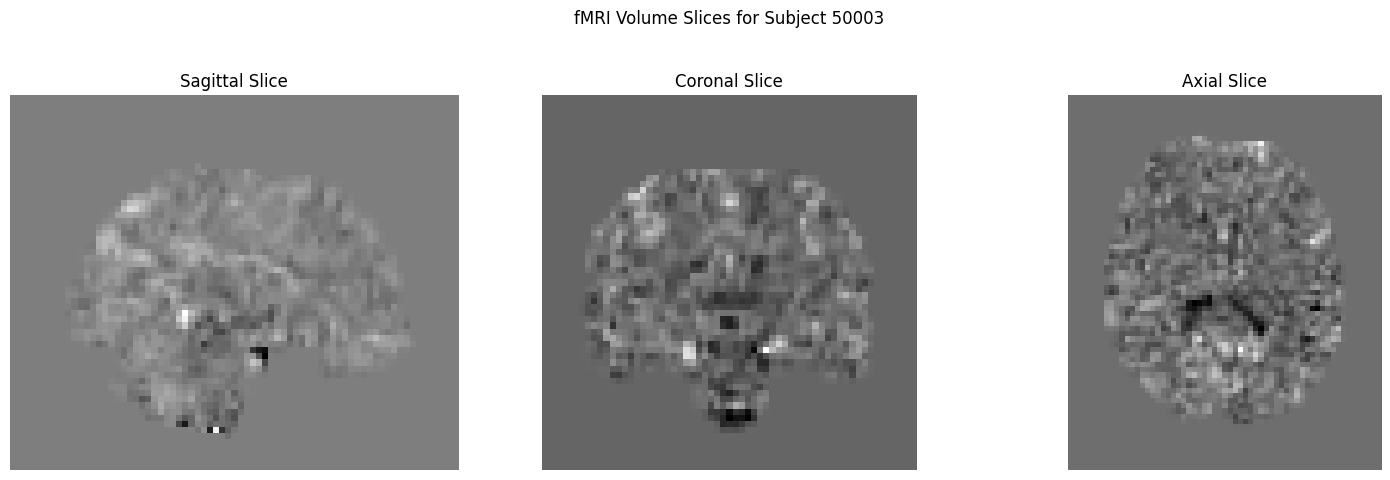

In [ ]:
subject_to_test_cnn = '50003'
cnn_data_for_viz = load_cnn_data(subject_to_test_cnn)

if cnn_data_for_viz is not None:
    print(f"Successfully loaded CNN data for subject {subject_to_test_cnn} with shape: {cnn_data_for_viz.shape}")
    visualize_mri_data(cnn_data_for_viz, title=f"fMRI Volume Slices for Subject {subject_to_test_cnn}")
else:
    print(f"Failed to load CNN data for subject {subject_to_test_cnn}.")